This notebook will introduce the basics of creating a pyro distribution and
sampling from it. To begin with, we create the standard normal distribution.

In [2]:
import matplotlib.pyplot as plt
import pyro
import numpy as np
import torch

pyro.set_rng_seed(100)
mean = 0.
var = 1.
dist = pyro.distributions.Normal(mean, var)

So far there's nothing special about this. We could have created a Pytorch (or
Tensorflow, etc.) distribution without needing a PPL library. Let's move on to
sampling.

In [3]:
rv_name = "standard_normal"
x = pyro.sample(rv_name, dist)
print(x)

tensor(0.3607)


Note that the `sample` function needs a `name` argument. The output of `sample`
is called a *site*, and the name allows us to refer to the same site from
separate pieces of code. We will see the usefulness of named sites later on.

Sampling a standard normal isn't very interesting, so let's try something more complex.

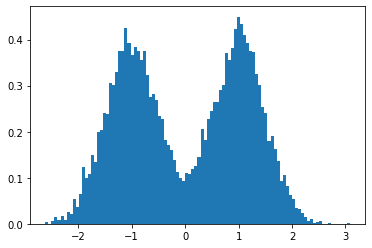

In [4]:
def bimodal():
    mode = pyro.sample('mode', pyro.distributions.Bernoulli(0.5))
    mean = -1. if mode == 0. else 1.
    var = 0.5
    x = pyro.sample('sample', pyro.distributions.Normal(mean, var))
    return x

samples = np.stack([bimodal() for _ in range(10000)])

plt.hist(samples, bins=100, density=True)
plt.show()

Here the function `bimodal` is a hierarchical statistical model. In the first
level of the hierarchy it samples a `0` or `1` from Bernoulli. Then, it samples
one of two Gaussians depending on the value samples from the Bernoulli. As we
might expect, the result is equivalent to sampling from
$$0.5 * \mathcal{N}(-1, 0.5) + 0.5 * \mathcal{N}(1, 0.5)$$

This is still pretty static. Pyro gives us a lot of power to construct models
dynamically and sample from them

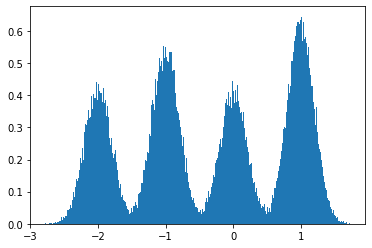

In [8]:
def multimodal(probits, n_samples, scale):
    probits = probits.expand(n_samples, -1)
    mode = pyro.sample('mode', pyro.distributions.Categorical(probits))
    means = (mode - probits.shape[-1] / 2)
    vars = scale * torch.ones_like(means)
    x = pyro.sample('sample', pyro.distributions.Normal(means, vars))
    return x

def make_multimodal(max_modes):
    n_modes = pyro.sample("n_modes",
                          pyro.distributions.Categorical(torch.ones(max_modes)))
    n_modes += 1
    probits = pyro.sample(
        "probits",
        pyro.distributions.Uniform(torch.zeros(n_modes), torch.ones(n_modes))
    )
    probits = torch.softmax(probits, dim=0)
    fn = lambda n_samples, scale: multimodal(probits, n_samples, scale)
    return fn

samples = make_multimodal(10)(100000, 0.2)

plt.hist(samples.cpu().numpy(), bins=500, density=True)
plt.show()

Here we used the higher order function `make_multimodal` to randomly sample the
number of modes and their weights, and the inner function `multimodal` to sample
a respective mixture of Gaussians. If  wanted, we could also pass the moments
of the individual Gaussians to `multimodal`, or create any other hierarchical
model of arbitrary depth and complexity. Feel free to play around and make your
own models.